In [1]:
# Setup code for the notebook
%matplotlib notebook
# Autoreload external python modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

from ipytools import display_imshow
from ipytools import readGTIFF  

# Functions 


In [6]:
def simple_equalization_8bit(im, percentiles=5):
    ''' im is a numpy array
        returns a numpy array
    '''
    import numpy as np
    mi, ma = np.nanpercentile(im.flatten(), (percentiles,100-percentiles))
    im = np.minimum(np.maximum(im,mi), ma) # clip
    im = (im-mi)/(ma-mi)*255.0   # scale
    im=im.astype(np.uint8)
    return im

In [7]:
import os
import copy
from ipytools import readGTIFF, writeGTIFF, readGTIFFmeta, display_gallery

In [8]:
def get_files(folder):
    """  Get all TIFF in the folder """
    tiff_dict = {1: [], 2:[], 3:[]}
    for dirname, dirnames, filenames in os.walk(folder):
        # print path to all filenames.
        for filename in filenames:
            if  filename.endswith('.tif'):
                complete_filename = os.path.join(dirname, filename)
                d = int(filename.split('_')[3][1])
                tiff_dict[d].append(complete_filename)
    for key in tiff_dict:
        tiff_dict[key] = sorted(tiff_dict[key])
    return tiff_dict

In [9]:
def retrieve_triplets():
    """ Build triplets from data """
    folders = {'1107':[], '1148':[], '1231':[]}
    min_len = float('inf')
    for f in folders:
        folder = '../data/s03_20161003T16' + f + 'Z/panchromatic/'
        folders[f] = get_files(folder)
    return folders

In [10]:
def display_triplets(d, i, folders, roi=None):
    """ Display chosen triplet """
    l = []
    g = []
    for f in folders:
        im_name = folders[f][d][i-1]
        g.append(im_name)
        im = readGTIFF(im_name)
        if (roi != None):
            x, y, w, h = roi["x"], roi["y"], roi["w"], roi["h"]
            im = im[y:y+h, x:x+w]
        print('Dimension: ', im.shape)
        l.append(simple_equalization_8bit(im))
    display_gallery(l, g)

In [120]:
def workaround_json_int64(o):
    if isinstance(o,np.integer) : return int(o)
    raise TypeError

In [121]:
import json
def write_json(d, i, folders, indices, roi=None):
    """ Write JSON with chosen triplets """
    # Get current config file
    with open('config.json', 'r') as f:
        user_cfg = json.load(f)
    user_cfg['out_dir'] = './output'
    # Config path of images and RPC
    images = []
    for j in indices:
        img_dict = {}
        img_name = folders[j][d][i-1]
        img_dict['img'] = img_name
        img_dict['rpc'] = '..' + img_name.split('.')[2] + '_rpc.txt'
        images.append(img_dict)
    user_cfg['images'] = images
    # Tile size
    user_cfg["tile_size"] = 1000
    # Config ROI 
    if (roi == None):
        user_cfg["full_img"] = True
    else:
        user_cfg["full_img"] = False
        user_cfg["roi"] = roi
    # Modify config file   
    with open('config.json', 'w') as f:
        json.dump(user_cfg, f, indent=2, default=workaround_json_int64)

In [130]:
def get_rectified_images():
    """ Get rectified images after applying s2p """
    name_images = []
    for dirname, dirnames, filenames in os.walk('./output/tiles'):
        if (dirname.split('/')[-1] == 'pair_1'):
            for filename in filenames:
                complete_filename = os.path.join(dirname, filename)
                # Depending on succes or not
                if (filename == 'stderr.log'):
                    print("NOT MATCHES in "+complete_filename)
                if (filename == 'rectified_ref.tif'):
                    name_images.append(dirname)
    return name_images

# Execution of s2p on Plantet's data

In [11]:
folders = retrieve_triplets()

In [92]:
d = 2
i = 11

Dimension:  (1349, 3199, 1)
Dimension:  (1349, 3199, 1)
Dimension:  (1349, 3199, 1)



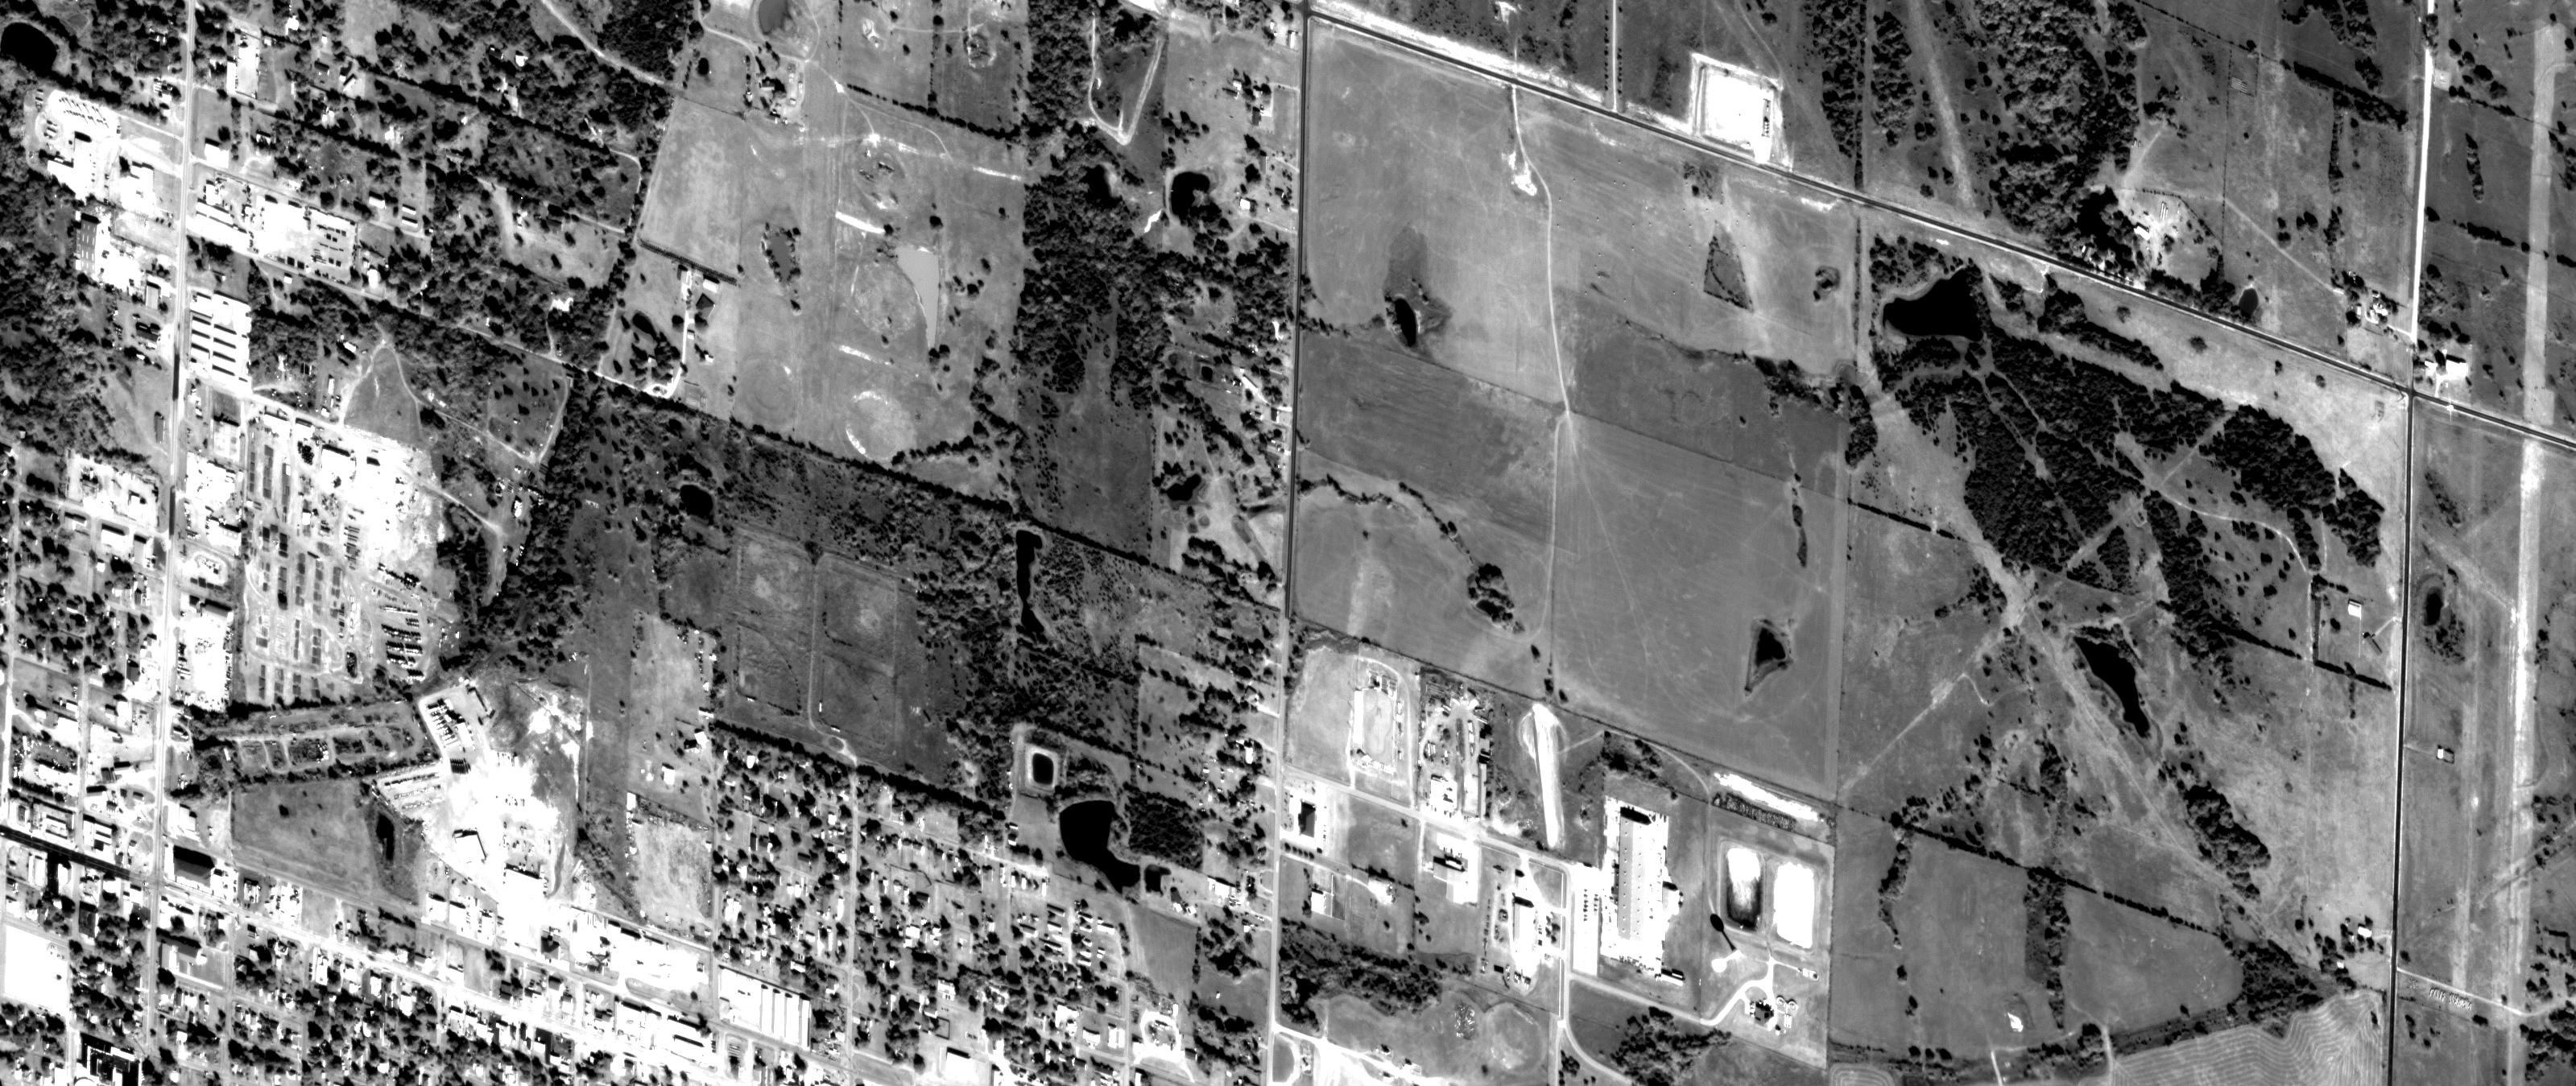
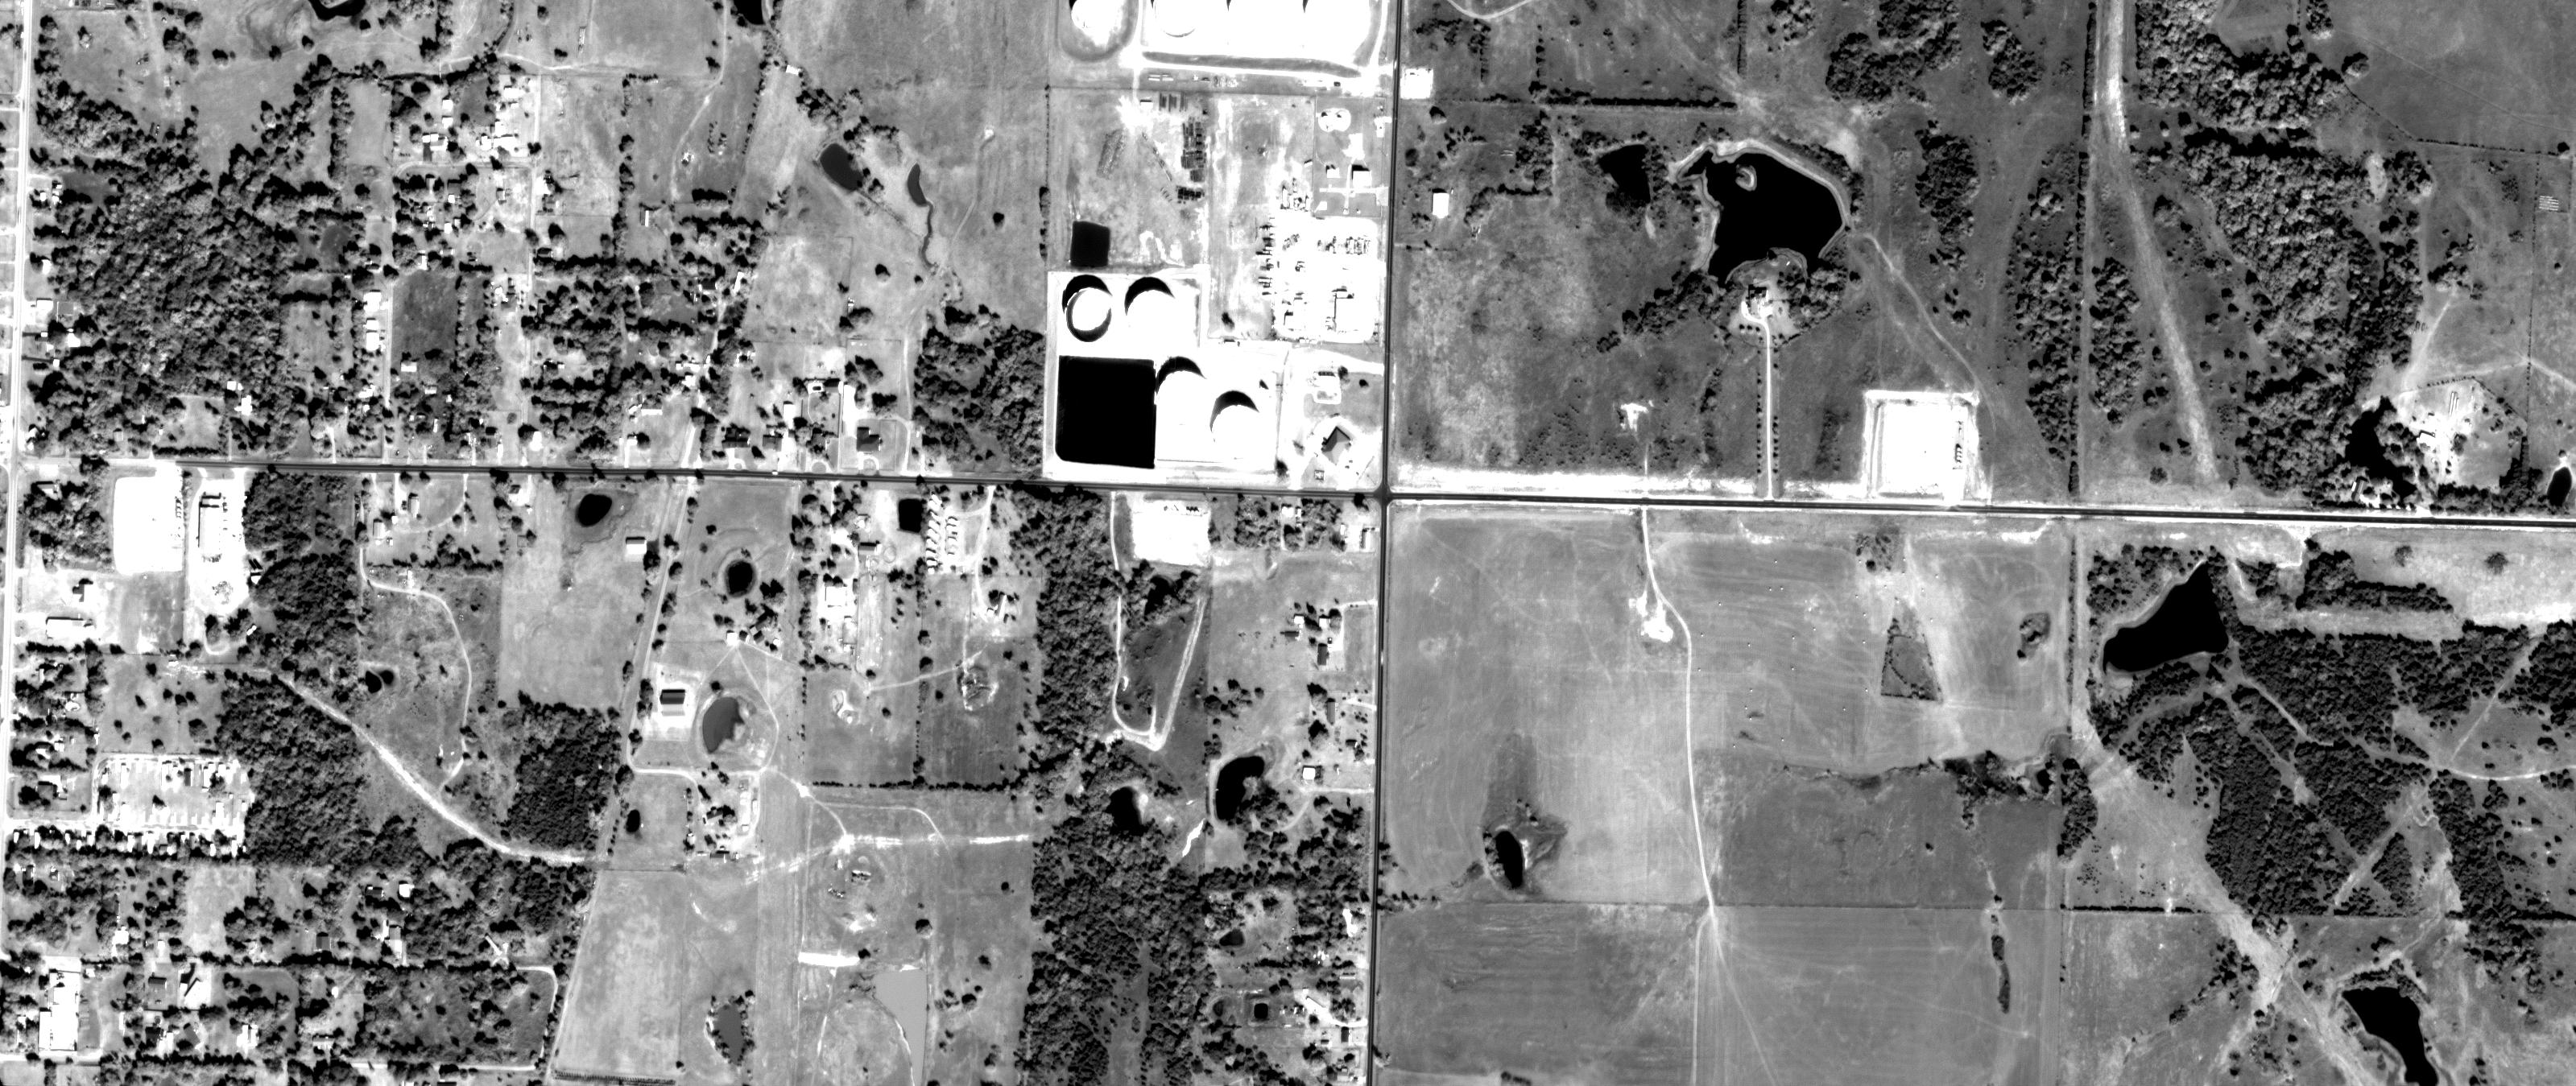
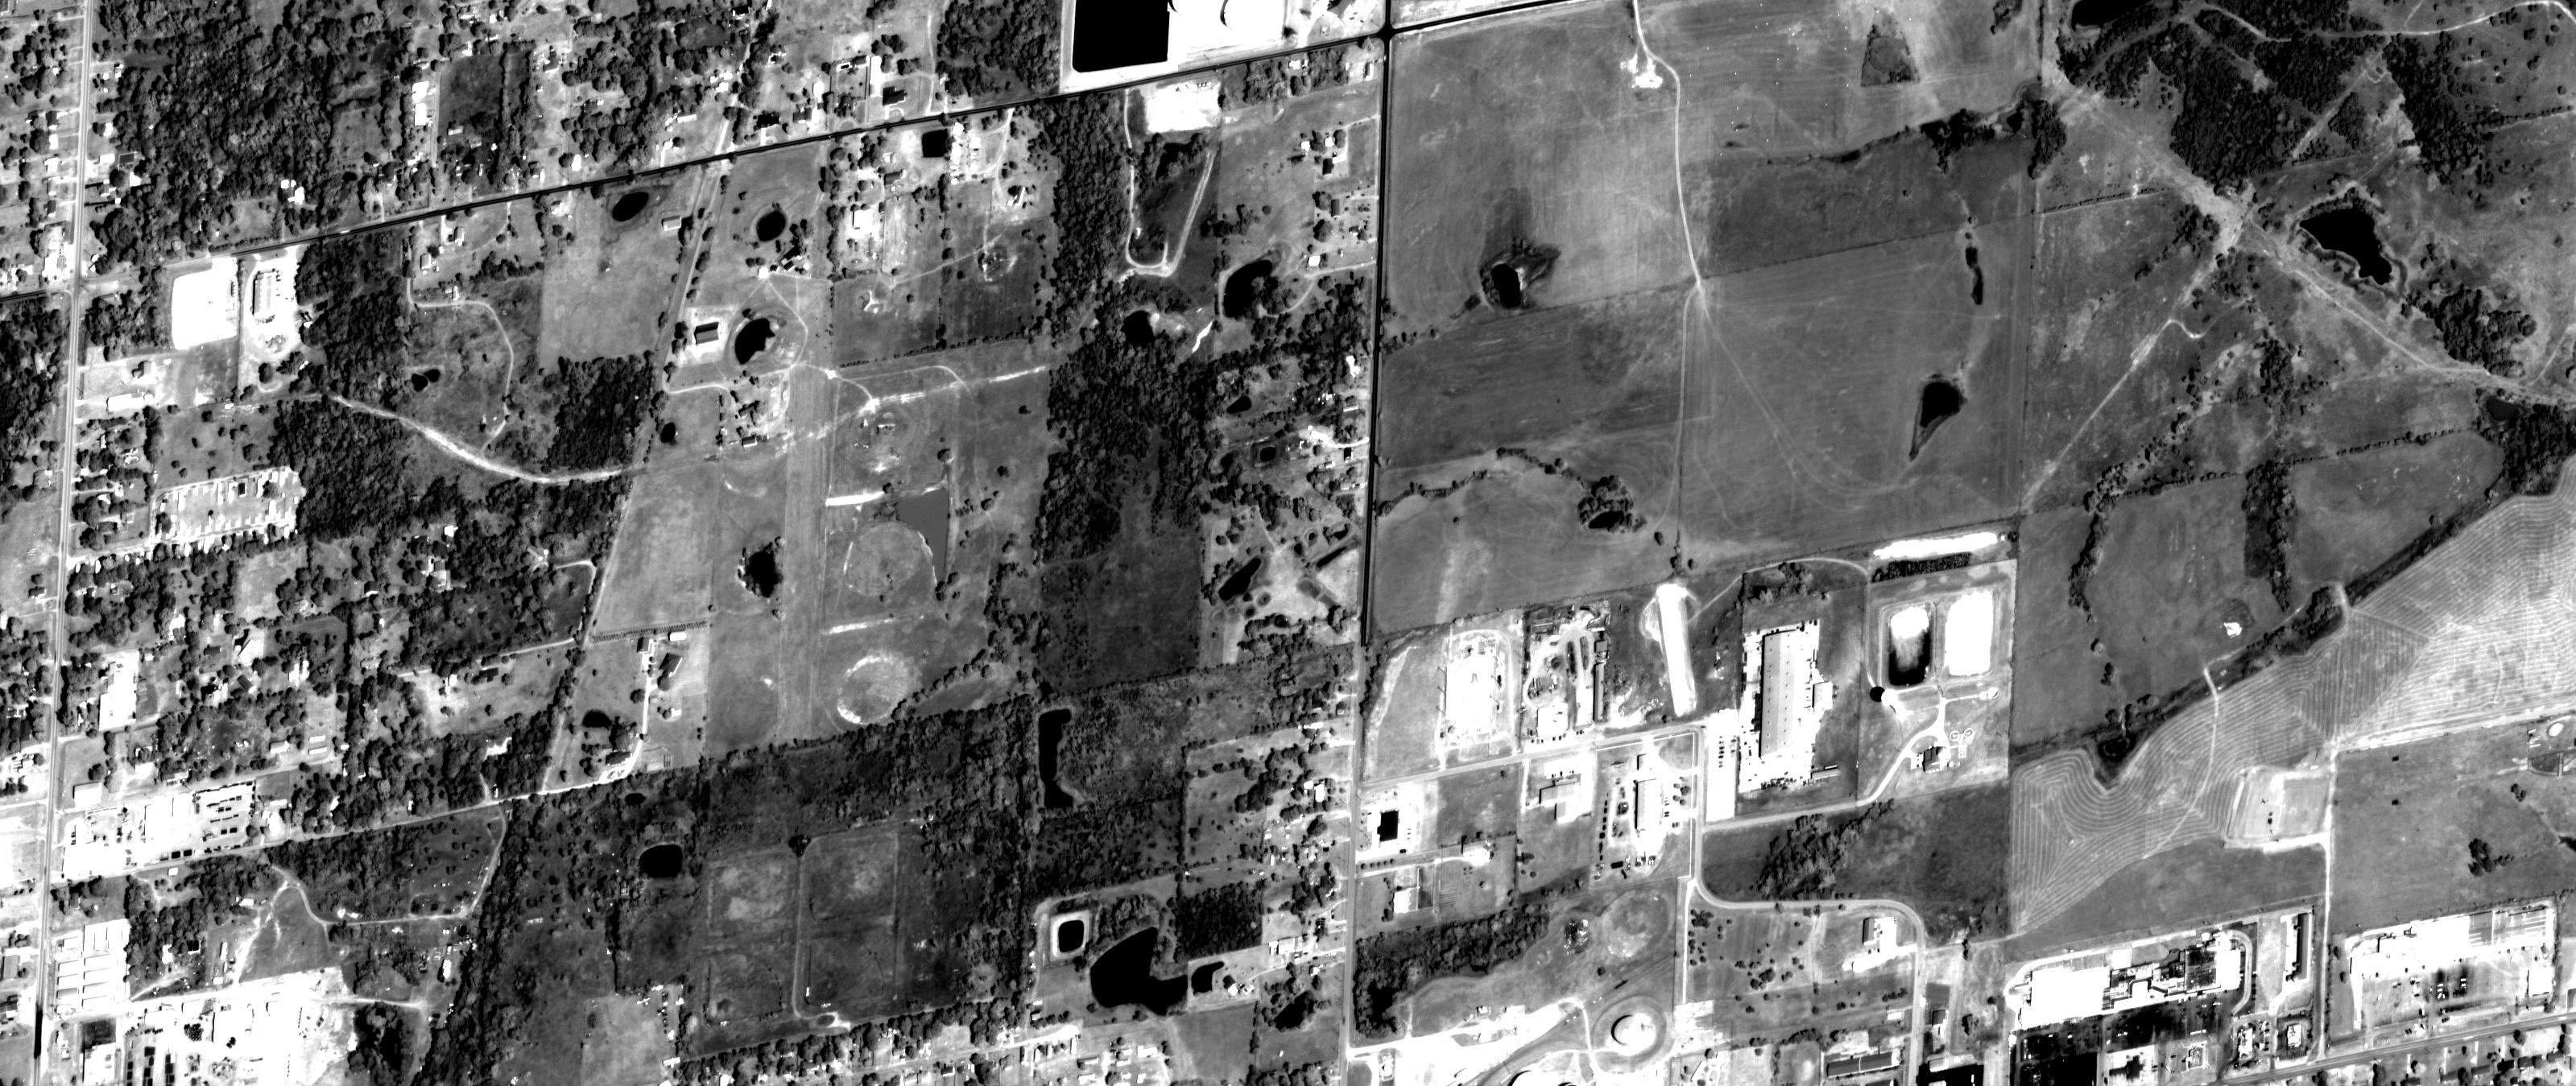

In [93]:
display_triplets(d, i, folders) #roi)

In [107]:
roi = {
    "x": 0,
    "y": 0,
    "w": 1000,
    "h": 1000
  }

Dimension:  (1000, 1000, 1)
Dimension:  (1000, 1000, 1)
Dimension:  (1000, 1000, 1)



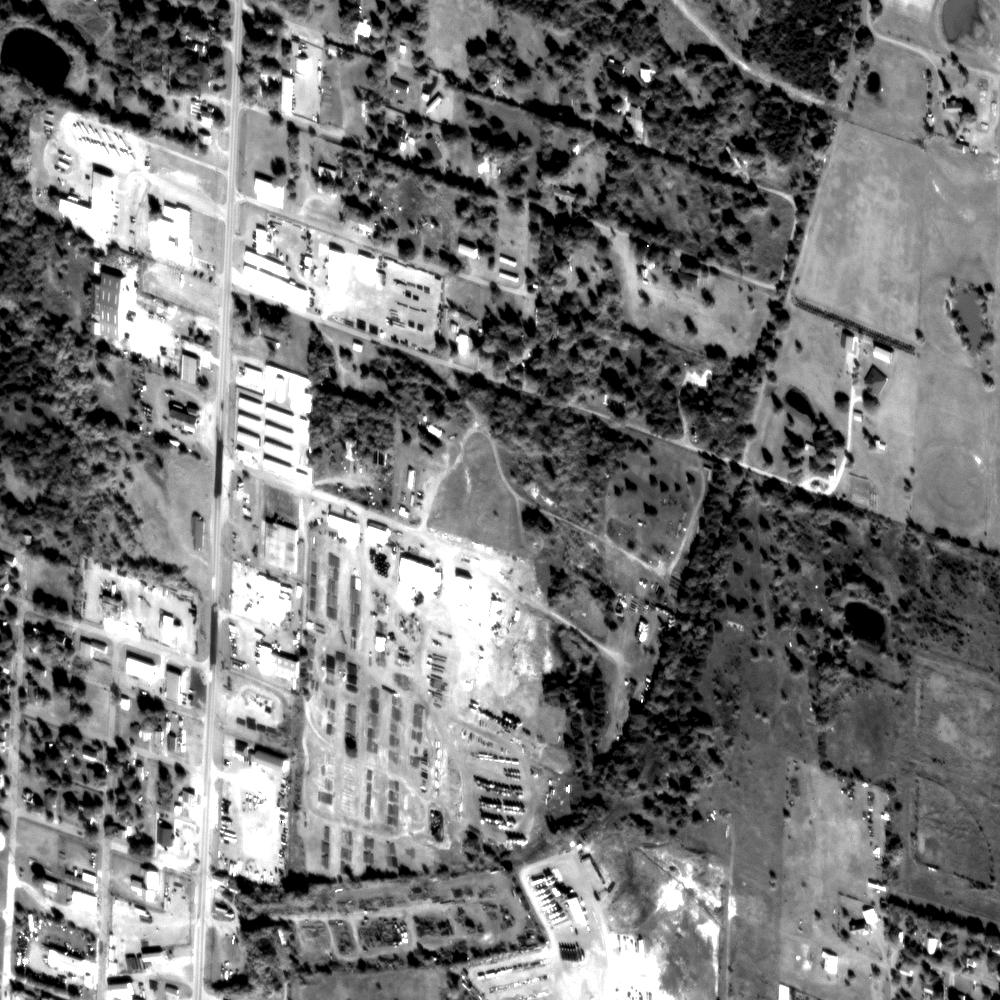
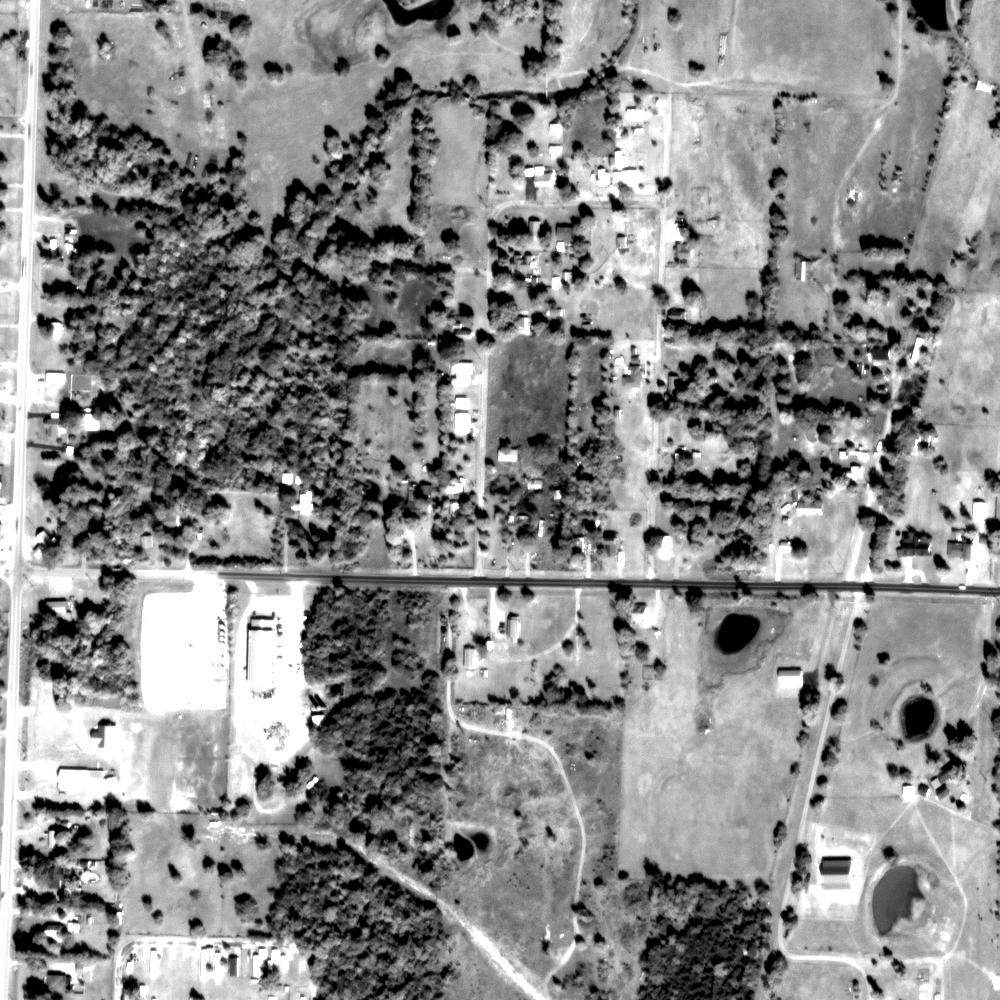
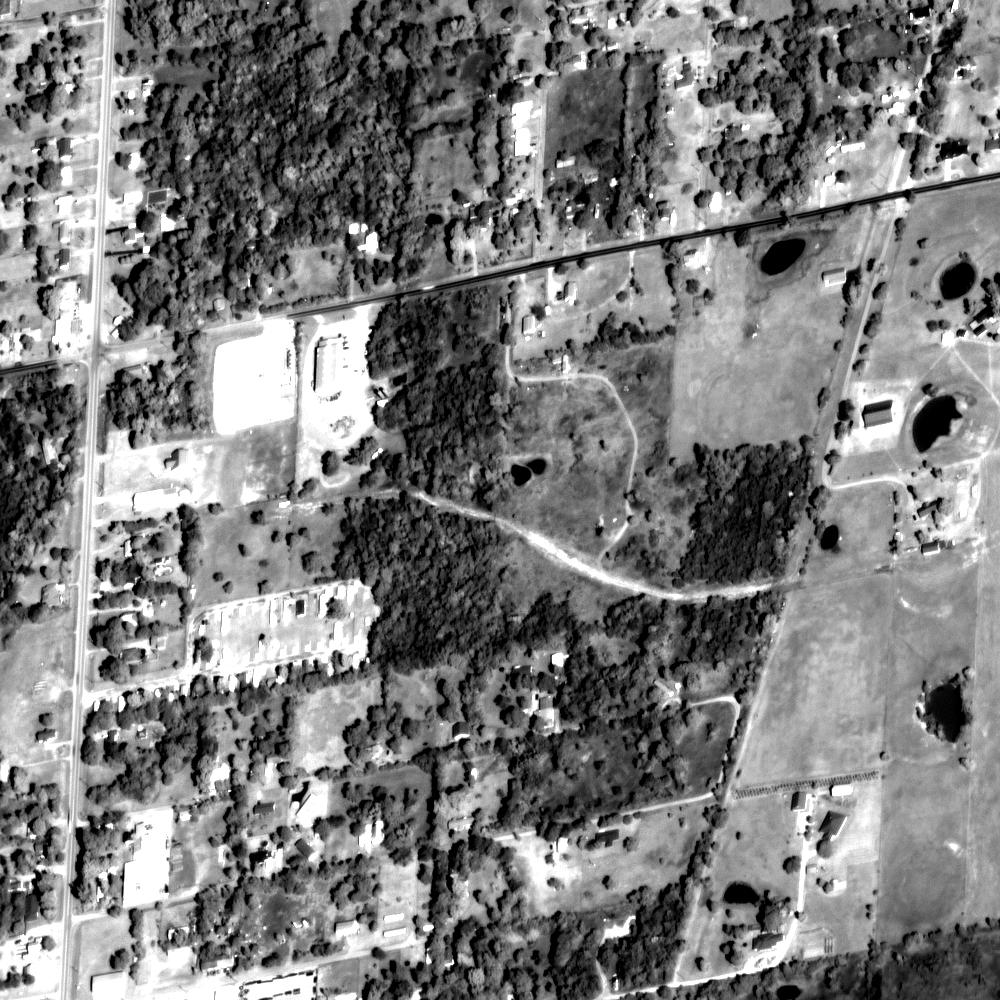

In [108]:
display_triplets(d, i, folders, roi)

In [122]:
write_json(d, i, folders, ['1148' , '1231'], roi)

In [140]:
!rm -rf output && cd .. && python3 s2p.py yaw_extension/config.json

out_dir is: /Users/juleskozolinsky/Projets/s2p/yaw_extension/./output
tile size: 1000 1000
total number of tiles: 1 (1 x 1)

discarding masked tiles...
done 1 / 1 tiles
Elapsed time: 0:00:00.130276

correcting pointing locally...
correcting pointing on tile 0 0 pair 1...

RUN: sift_roi /Users/juleskozolinsky/Projets/s2p/yaw_extension/../data/s03_20161003T161148Z/panchromatic/s03_20161003T161148Z_pan_d2_0011.tif 0 0 1000 1000 --thresh-dog 0.013300 -o /tmp/s2p_v5p8yyci.txt
0:00:02.514232

RUN: sift_roi /Users/juleskozolinsky/Projets/s2p/yaw_extension/../data/s03_20161003T161231Z/panchromatic/s03_20161003T161231Z_pan_d2_0011.tif 60 -345 981 1055 --thresh-dog 0.013300 -o /tmp/s2p_qfo_0e0u.txt
0:00:01.794801

RUN: matching /tmp/s2p_v5p8yyci.txt /tmp/s2p_qfo_0e0u.txt -relative 0.600000 -o /tmp/s2p_sz3q6pla.txt -f "0.7236353367544944 0.16510605255057653 -0.6587369023473799 -0.12311614149718117 -37.64709053432011"
62 matches
0:00:03.151468

RUN: ransac fmn 1000 .3 7 /tmp/s2p_sz3q6pla.txt < /tm

In [141]:
name_images = get_rectified_images()
print(name_images)
key = name_images[0]

['./output/tiles/row_0000000_height_1000/col_0000000_width_1000/pair_1']


In [142]:
import numpy as np
A = np.loadtxt(key + '/pointing.txt', usecols=range(3))

[[ 3.12699464e-01 -9.49852118e-01 -8.54227670e-04]
 [ 9.49852118e-01  3.12699464e-01 -9.13228705e-03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]



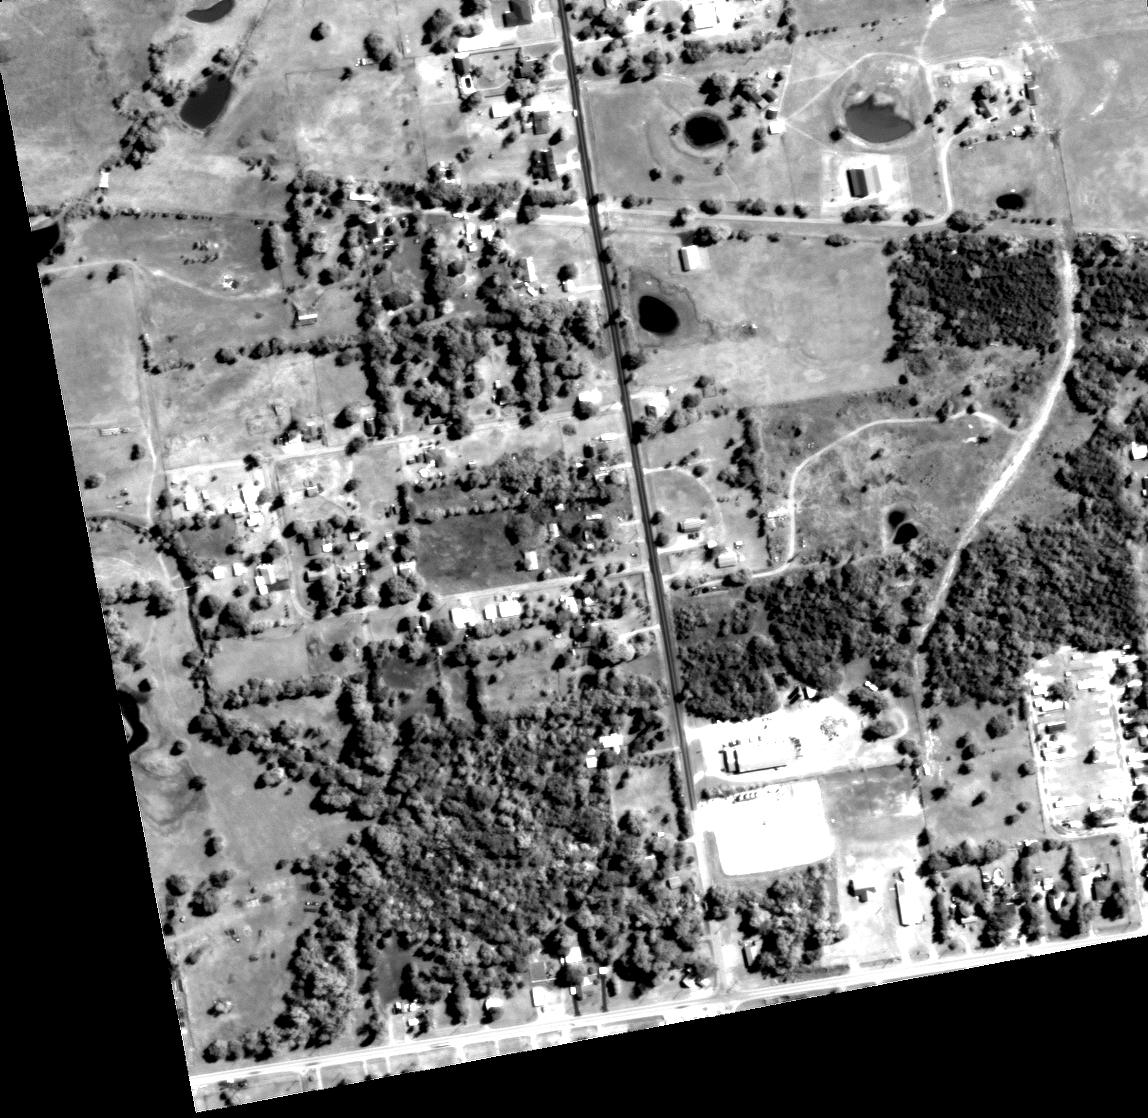
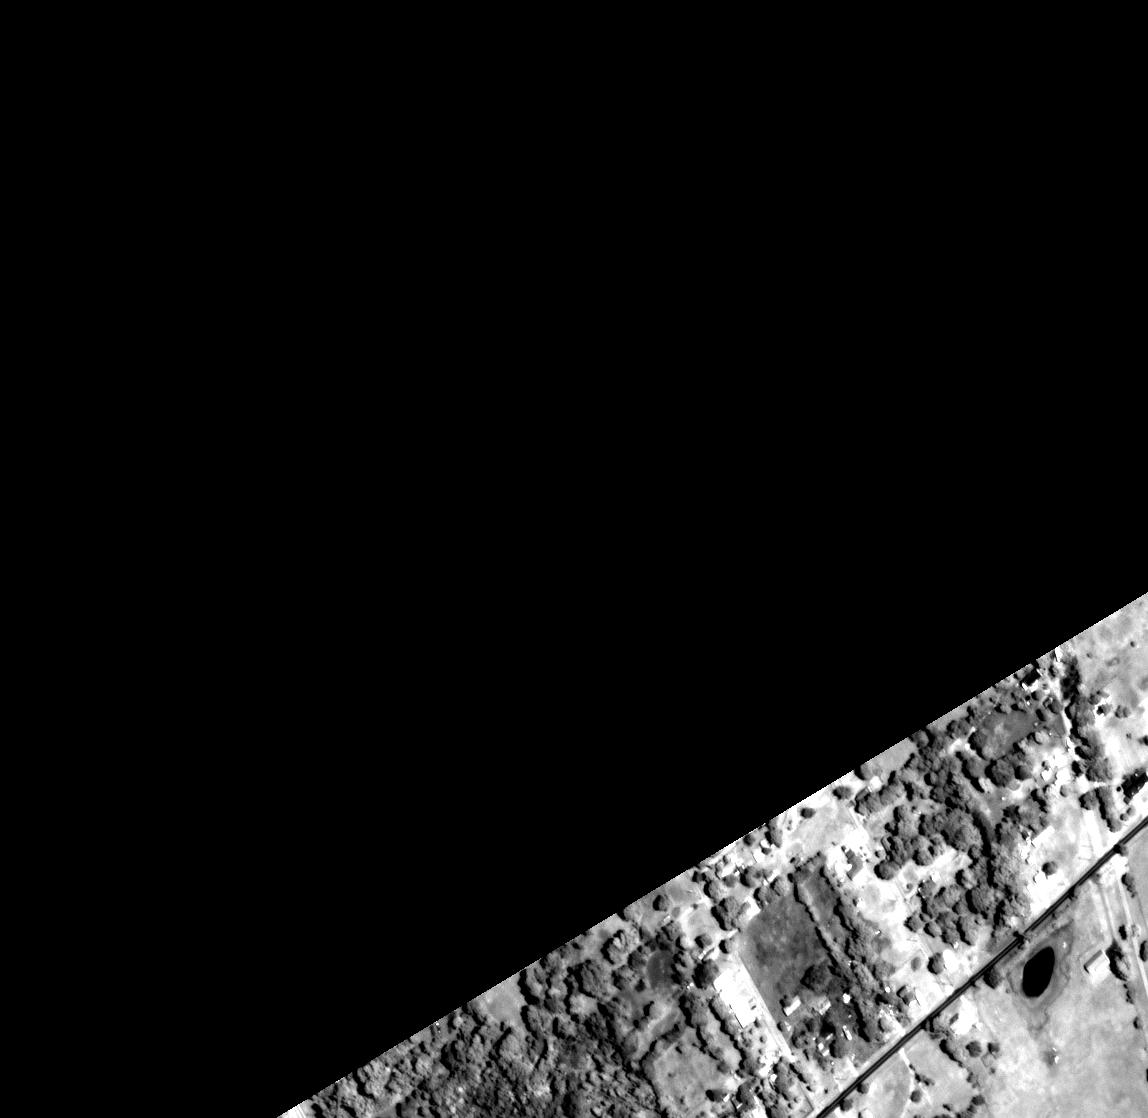

In [132]:
a_ref = key + '/rectified_ref.tif'
a_sec = key + '/rectified_sec.tif'
display_gallery([simple_equalization_8bit(readGTIFF(a_ref)), simple_equalization_8bit(readGTIFF(a_sec))])

<IPython.core.display.Javascript object>


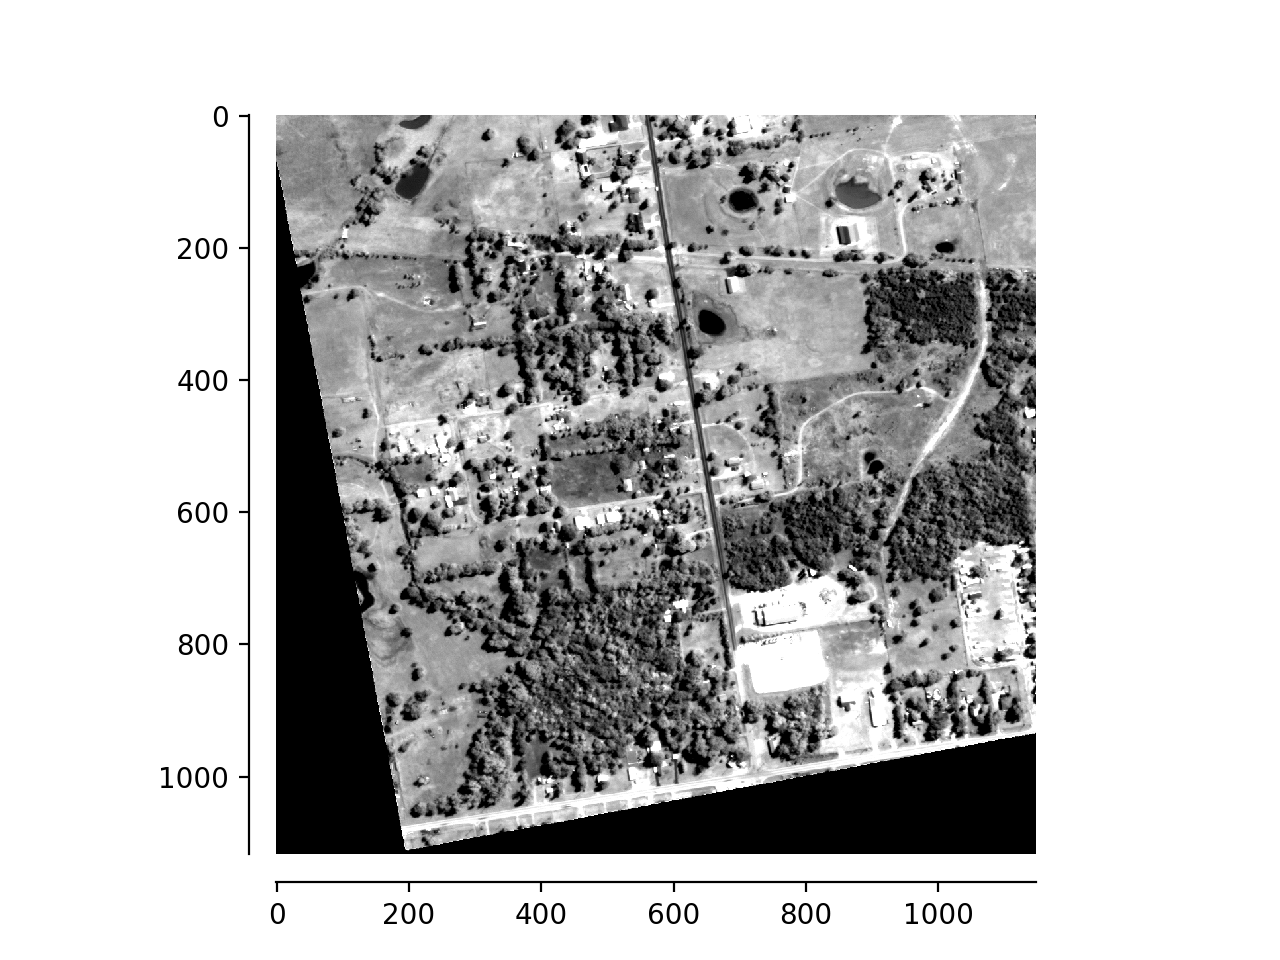

In [133]:
display_imshow(simple_equalization_8bit(readGTIFF(a_ref)))

<IPython.core.display.Javascript object>


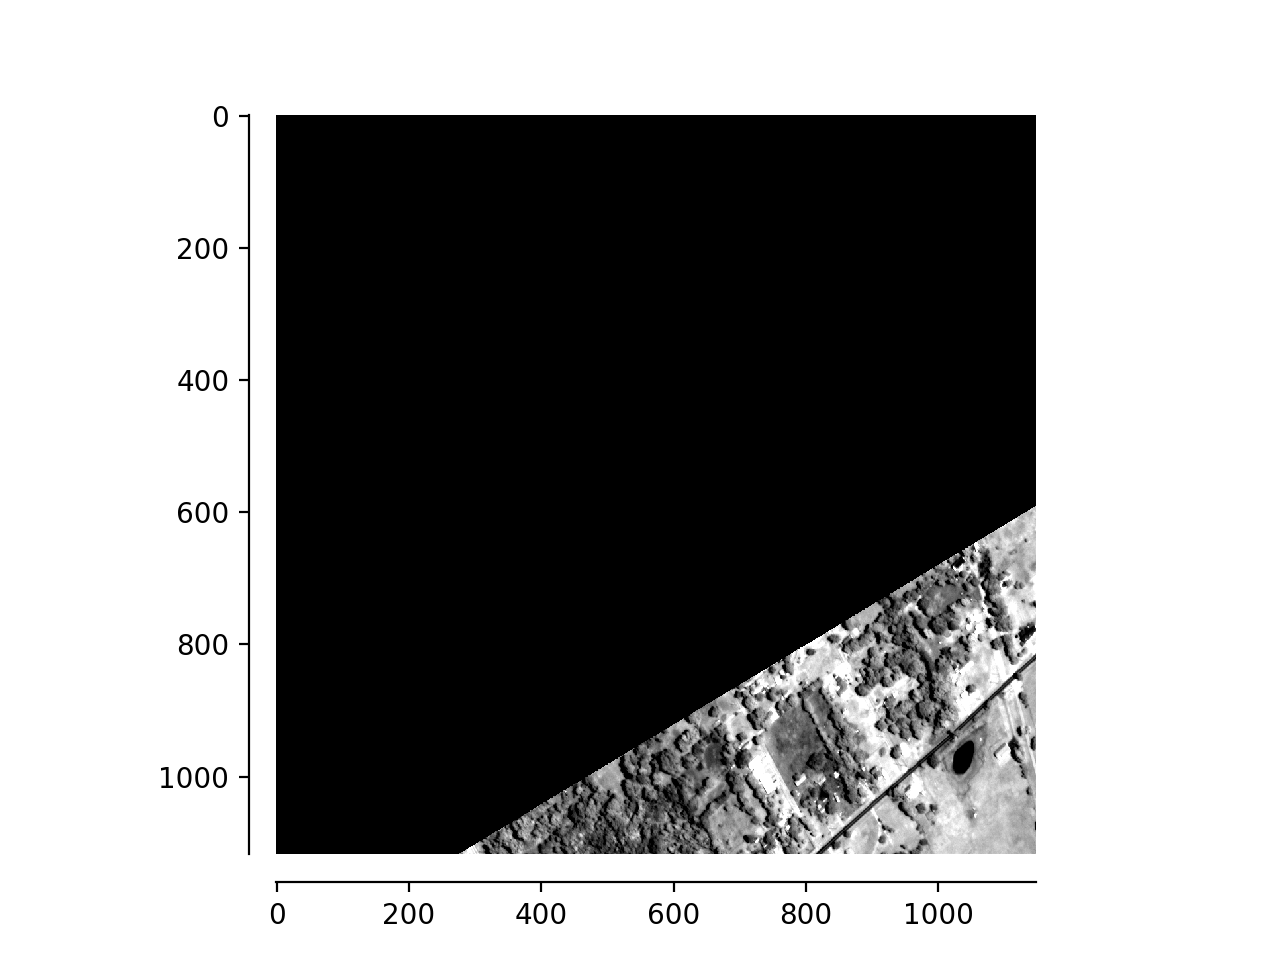

In [134]:
display_imshow(simple_equalization_8bit(readGTIFF(a_sec)))

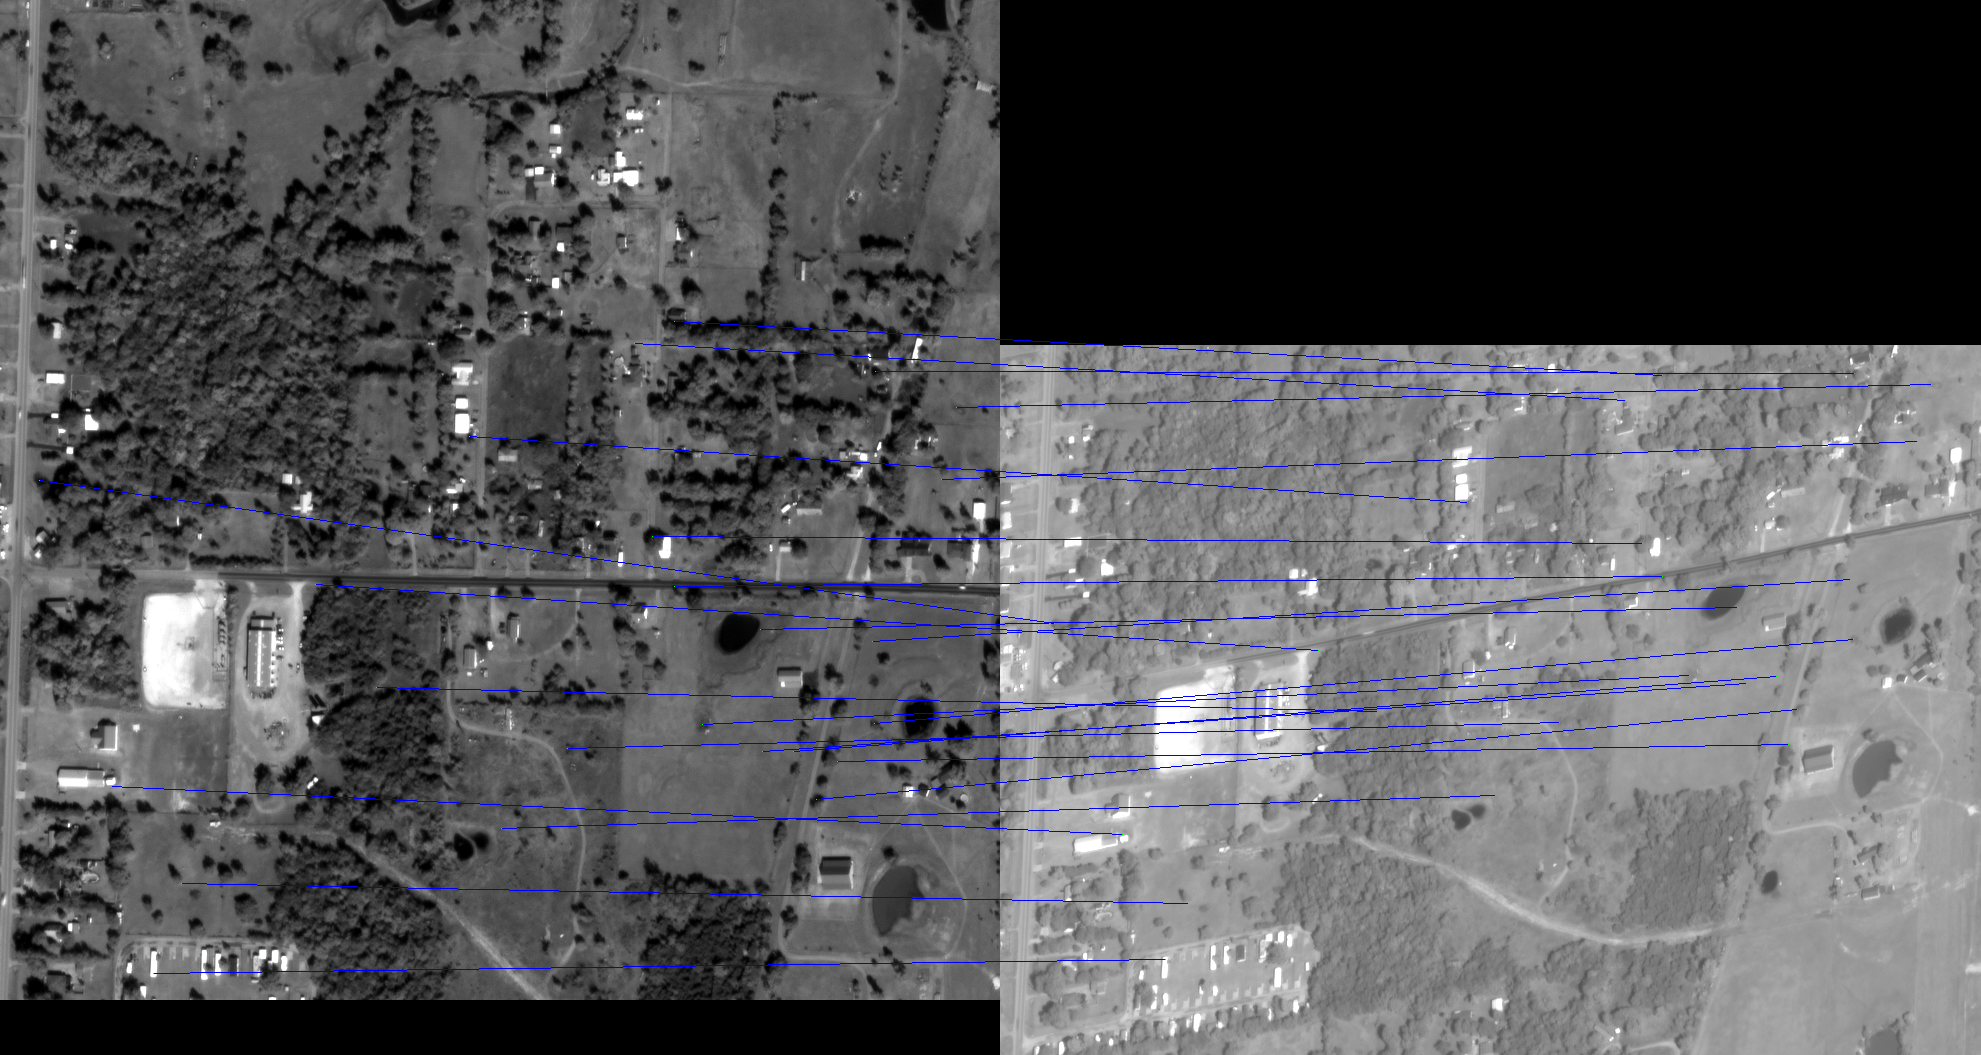

In [135]:
from IPython.display import Image
filename = key + '/sift_matches_pointing.png'
Image(filename=filename) 

In [106]:
expected_output = './output/s03_20161003T161107Z/dsm.tif'
a = readGTIFF(expected_output)

RasterioIOError: ./output/s03_20161003T161107Z/dsm.tif: No such file or directory

<IPython.core.display.Javascript object>


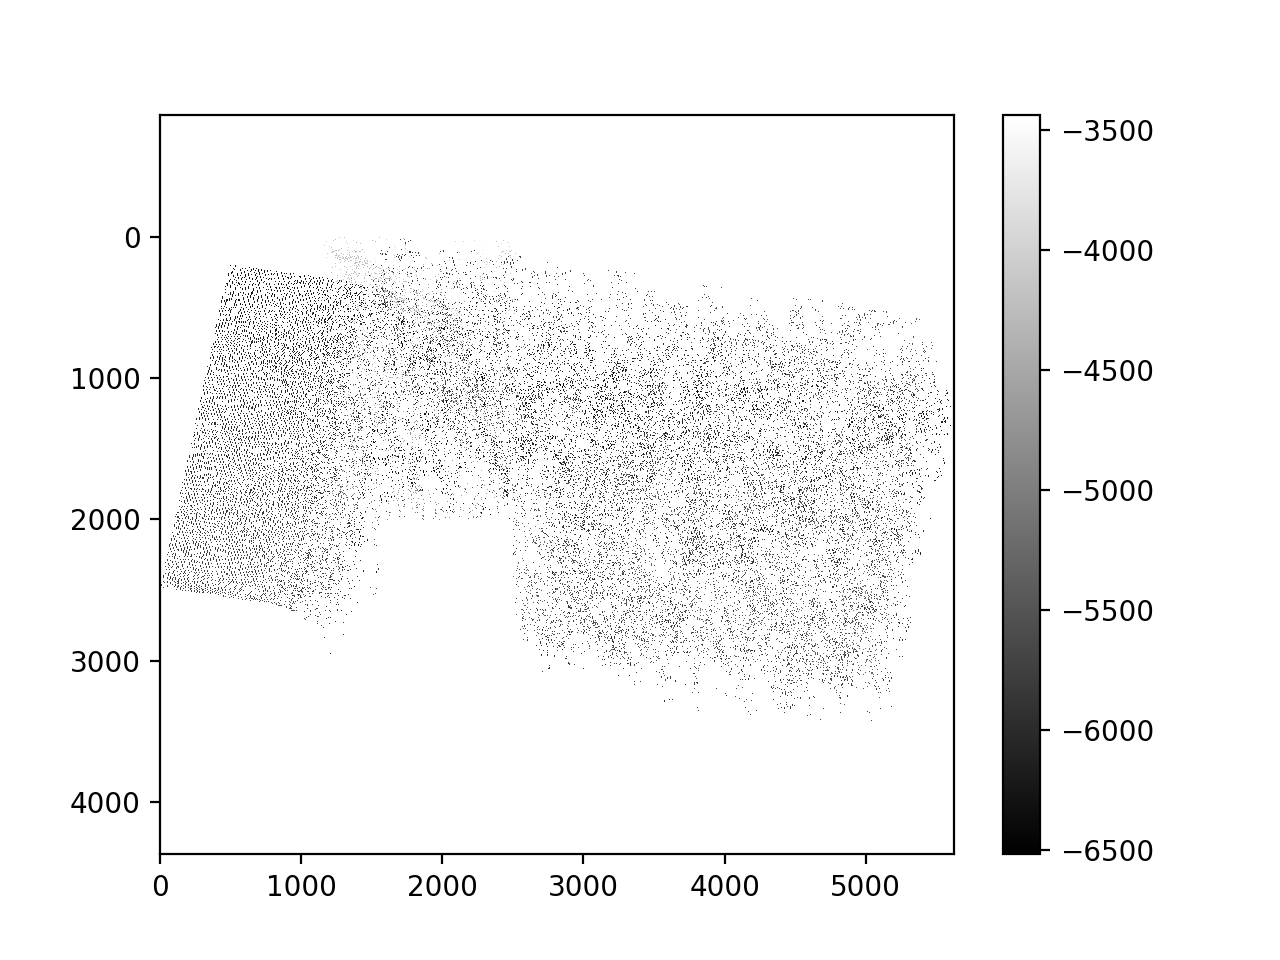

In [18]:
b = a#readGTIFF('/Users/juleskozolinsky/Projets/s2p/yaw_extension/output/s03_20161003T161107Z/tiles/row_0000000_height_500/col_0001000_width_500/dsm.tif')
display_imshow(b)